In [1]:
import pandas as pd
import numpy as np
import os
from mplsoccer.pitch import Pitch
from mplsoccer.scatterutils import arrowhead_marker
from scipy.stats import circmean

Get pass data

In [2]:
STATSBOMB = os.path.join('..', 'data', 'statsbomb')
df_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_pass = df_event[df_event.type_name == 'Pass'].copy()
df_pass = df_pass[(df_pass.outcome_name.isnull()) & 
                  (~df_pass.pass_type_name.isin(['Throw-in', 'Free Kick', 'Goal Kick', 'Kick Off', 'Corner']))].copy()

Pitch setup

In [3]:
pitch = Pitch(line_zorder=3, figsize=(16, 9), line_color='black')

# Bin data by grid

Pass angles

In [4]:
x_dist = df_pass.end_x - df_pass.x
if pitch.invert_y:
    y_dist = df_pass.y - df_pass.end_y
else:
    y_dist = df_pass.end_y - df_pass.y
pass_radians = np.arctan2(y_dist, x_dist)
# if negative angle make positive angle, so goes from 0 to 2 * pi
pass_radians[pass_radians < 0] = 2 * np.pi + pass_radians[pass_radians < 0]

Calculate average angle

In [5]:
bins = (12, 8)  # bins for calculation: number of bins in x direction, number of bins in y direction
bs_angle = pitch.bin_statistic(x=df_pass.x, y=df_pass.y, values=pass_radians, statistic=circmean, bins=bins)

Create Arrows

In [6]:
d = 5  # length of arrow
changex = (np.cos(bs_angle['statistic']) * d)
changey = -(np.sin(bs_angle['statistic']) * d)  
endx = bs_angle['cx'] + changex
endy = bs_angle['cy'] + changey    
startx = bs_angle['cx']
starty = bs_angle['cy']

Calculate heatmap

In [7]:
bs_heatmap = pitch.bin_statistic(df_pass.x, df_pass.y, statistic='count', bins=bins)

Draw plot

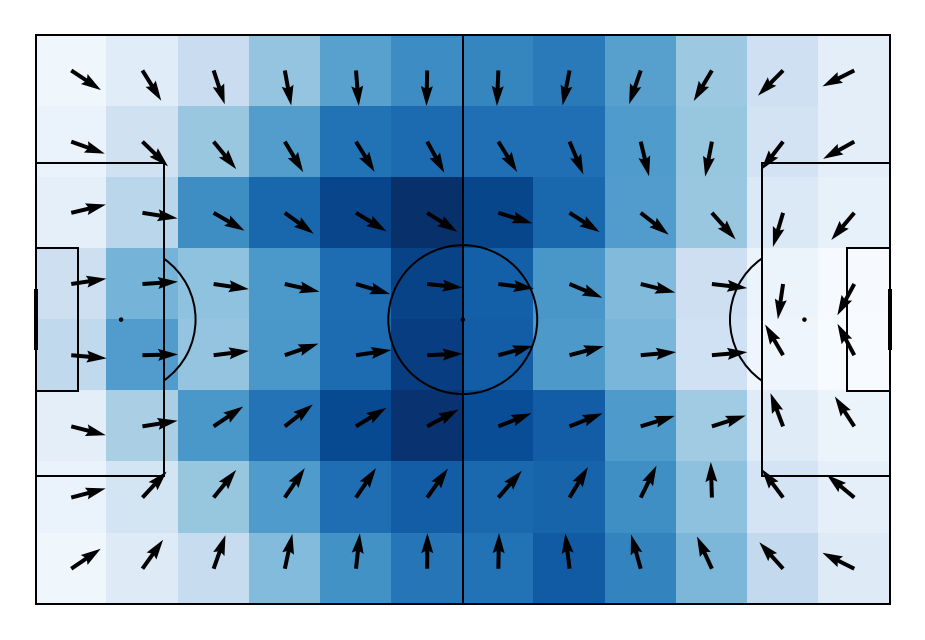

In [8]:
fig, ax = pitch.draw()
pitch.heatmap(bs_heatmap, ax=ax, cmap='Blues')
pitch.arrows(startx, starty, endx, endy, ax=ax, zorder=3)

# Plot as a rotated scatter instead

Get angle in degrees clockwise and plot as scatter plot

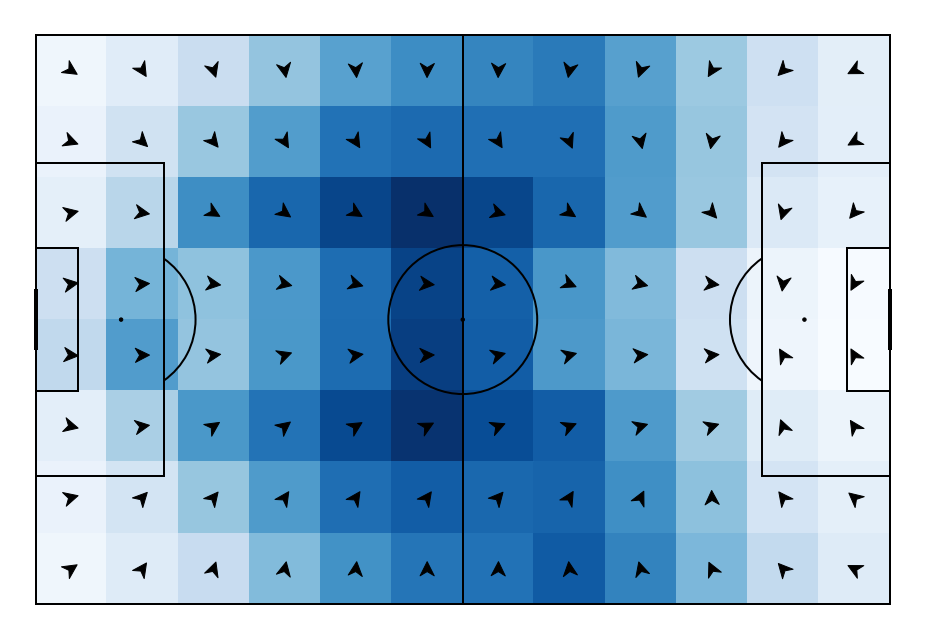

In [9]:
# turn anticlockwise into clockwise
bs_angle['statistic'] = 2 * np.pi - bs_angle['statistic']
# turn into degrees
bs_angle['statistic'] = np.degrees(bs_angle['statistic']).round(0).astype(np.int32)
# plot
fig, ax = pitch.draw()
pitch.heatmap(bs_heatmap, ax=ax, cmap='Blues')
pitch.scatter(bs_angle['cx'], bs_angle['cy'], rotation_degrees=bs_angle['statistic'],
              s=200, c='black', marker=arrowhead_marker, ax=ax)

# Bin using Juego de Posición

In [10]:
bs_heatmap = pitch.bin_statistic_positional(df_pass.x, df_pass.y, statistic='count')
bs_angle = pitch.bin_statistic_positional(x=df_pass.x, y=df_pass.y, values=pass_radians, statistic=circmean)

In [11]:
# above returns list of statistics convert to flat form
angle = np.concatenate([bs['statistic'].ravel() for bs in bs_angle])
cx = np.concatenate([bs['cx'].ravel() for bs in bs_angle])
cy = np.concatenate([bs['cy'].ravel() for bs in bs_angle])

In [12]:
# calculate arrows
d = 5  # length of arrow
changex = (np.cos(angle) * d)
changey = -(np.sin(angle) * d)  
endx = cx + changex
endy = cy + changey    
startx = cx
starty = cy

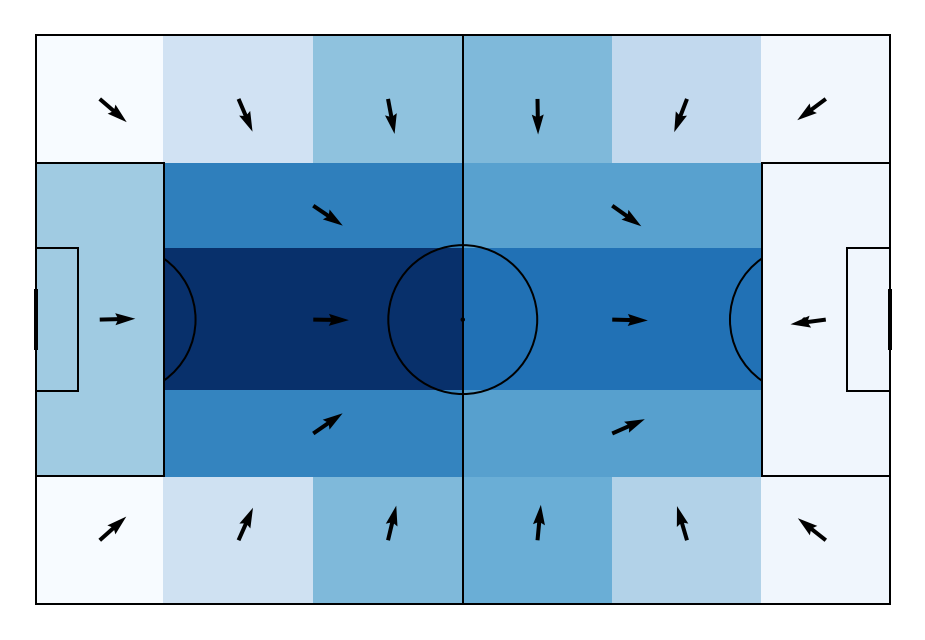

In [13]:
pitch.heatmap_positional(bs_heatmap, ax=ax, cmap='Blues')
# plot
fig, ax = pitch.draw()
hm = pitch.heatmap_positional(bs_heatmap, ax=ax, cmap='Blues')
pitch.arrows(startx, starty, endx, endy, ax=ax, zorder=3)